In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import tqdm

In [2]:
sns.set_style('whitegrid')


# Tabular Data
**clinical patient info and FVC**
- Patient (str): a unique Id for each patient (also the name of the patient's DICOM folder)
- Weeks (int): the relative number of weeks pre/post the baseline CT (may be negative)
- FVC (int): the recorded lung capacity in ml
- Percent (float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
- Age (int)
- Sex (str)
- SmokingStatus (str)

In [3]:
DATA_DIR="./data/"
train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(1549, 7)
(5, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
print(f"Found {train_df['Patient'].nunique()} unique patients")

Found 176 unique patients


### Distribution of FVC measurements

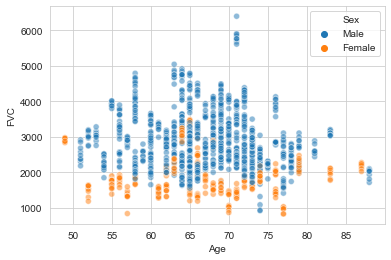

In [5]:
sns.scatterplot(data = train_df, x='Age', y='FVC', hue = 'Sex', alpha=.5);

C:\ProgramData\Anaconda3\envs\OSIC_EDA\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


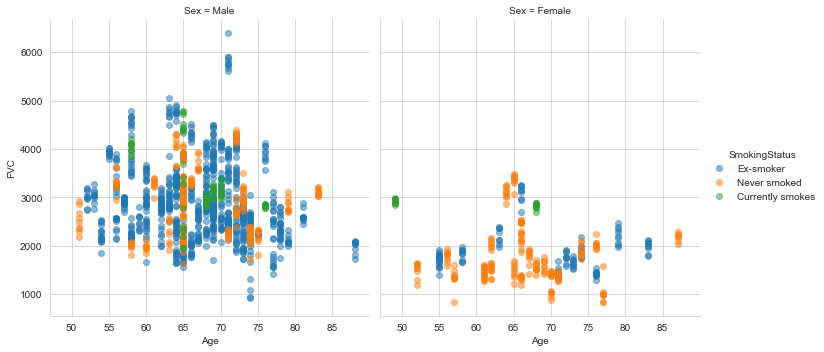

In [6]:
g = sns.FacetGrid(data = train_df, col='Sex', hue='SmokingStatus', size=5, aspect=1);
g = (g.map(plt.scatter, 'Age', 'FVC' ,alpha=.5).add_legend())

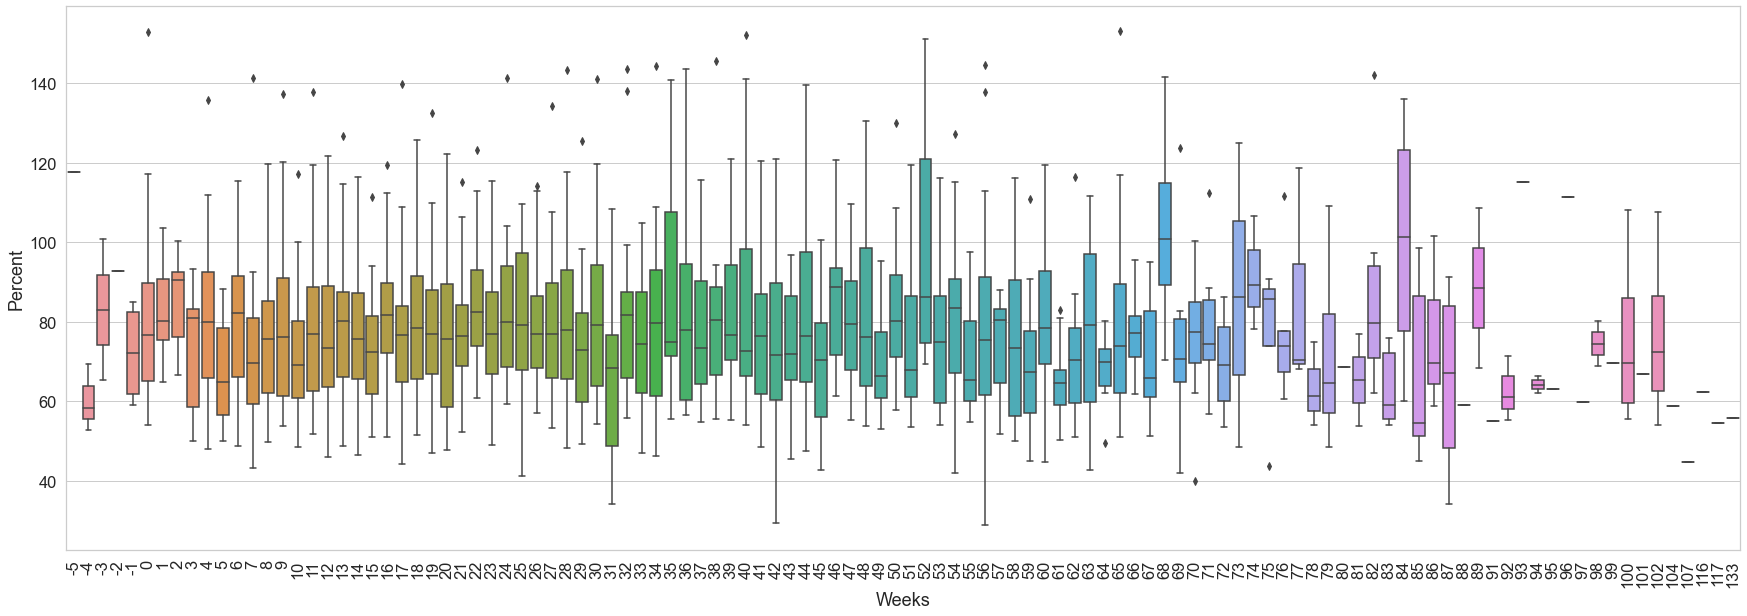

In [7]:
with sns.plotting_context("notebook",font_scale=1.5):
    fig, ax = plt.subplots(figsize=(30, 10))
    sns.boxplot(data=train_df, x='Weeks', y='Percent', ax=ax);
    plt.xticks(rotation=90);

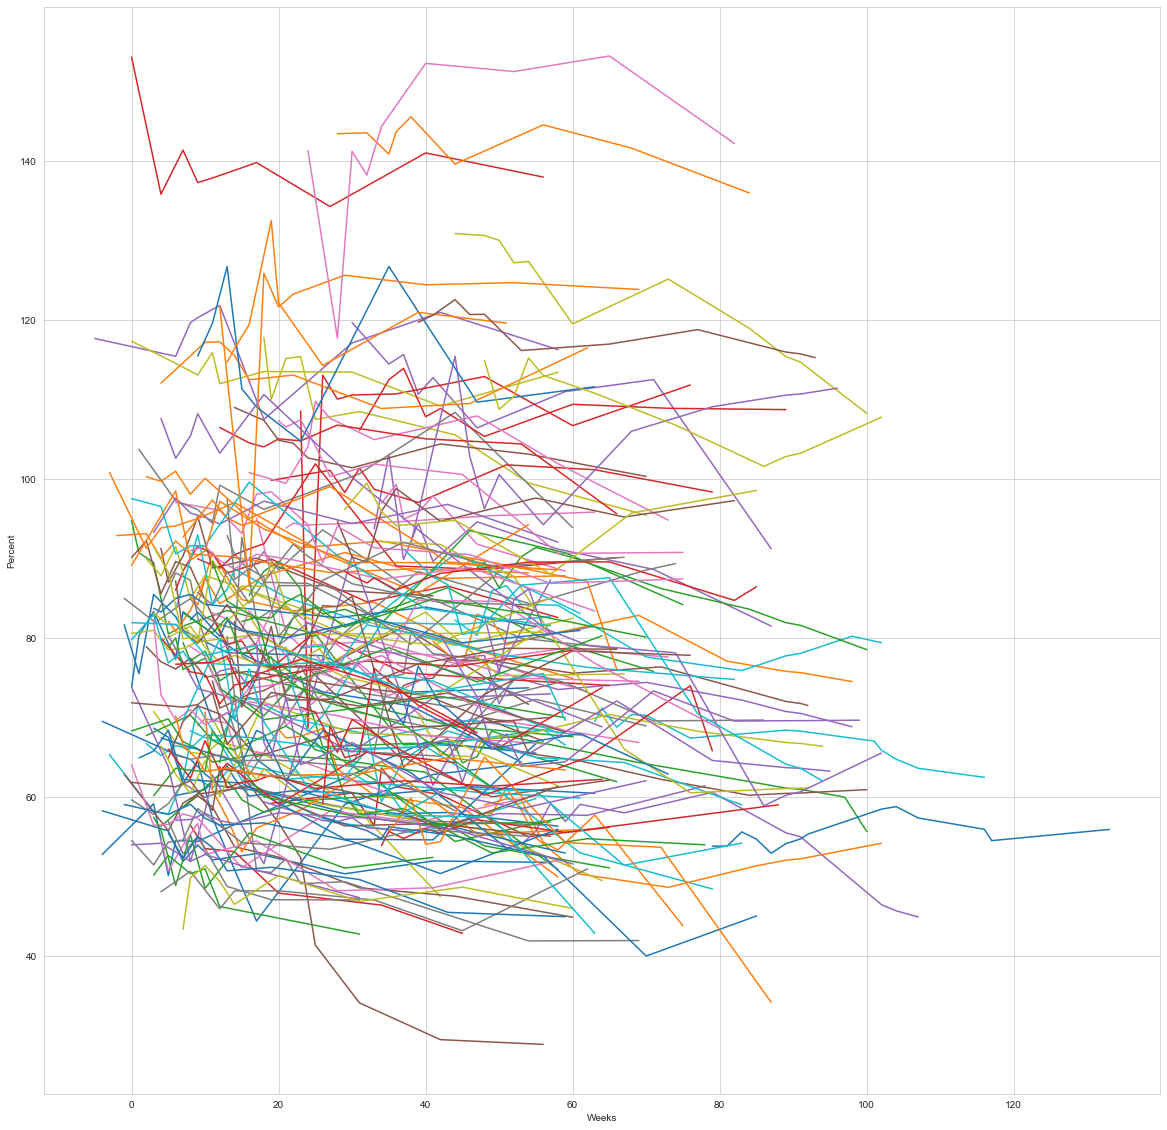

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
train_df.groupby(['Weeks','Patient'])['Percent']\
    .median()\
    .unstack()\
    .interpolate(method='linear', limit_area='inside')\
    .plot(ax=ax,legend=None);
plt.ylabel('Percent');

### Distribution of Age

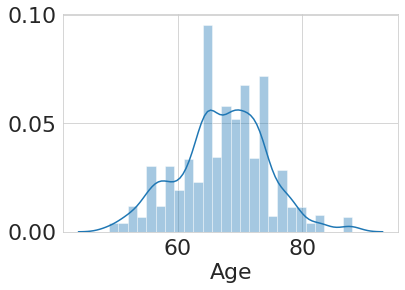

In [11]:
sns.distplot(train_df['Age']);

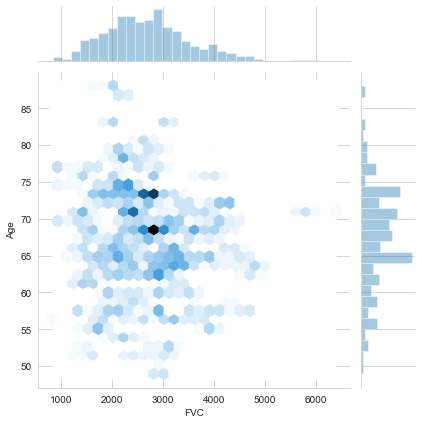

In [22]:
sns.jointplot(x="FVC", y="Age", data=train_df, kind="hex");

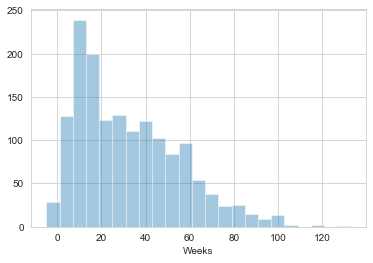

In [38]:
sns.distplot(train_df['Weeks'], kde=False);

## DICOM Data

In [8]:
DATA_DIR="./ALL_DATA/train"
train_dcms =  [path for path in Path(DATA_DIR).rglob('*.dcm')]
train_folders = os.listdir(DATA_DIR)
print(f'training set has {len(train_dcms)} total images, comprising {len(train_folders)} patients')

training set has 33026 total images, comprising 176 patients


In [9]:
# read a single DICOM header. OF NOTE:
# (0020, 0032) Image Position (Patient)     DS: [-158.700, -153.500, -69.750] --- x,y,z of image w.r.t. patient
# (0028, 0004) Photometric Interpretation   CS: 'MONOCHROME2' --- dark vs light value
# (0028, 1050) Window Center                DS: "-500.0" --- brightness
# (0028, 1051) Window Width                 DS: "-1500.0" --- contrast
# (7fe0, 0010) Pixel Data                   OW: Array of 524288 elements --- pixel data as byte array
print(train_dcms[0])
dimg = pydicom.dcmread(train_dcms[0])
dimg

ALL_DATA\train\ID00007637202177411956430\1.dcm


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12297650151329871895440507938349160734
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

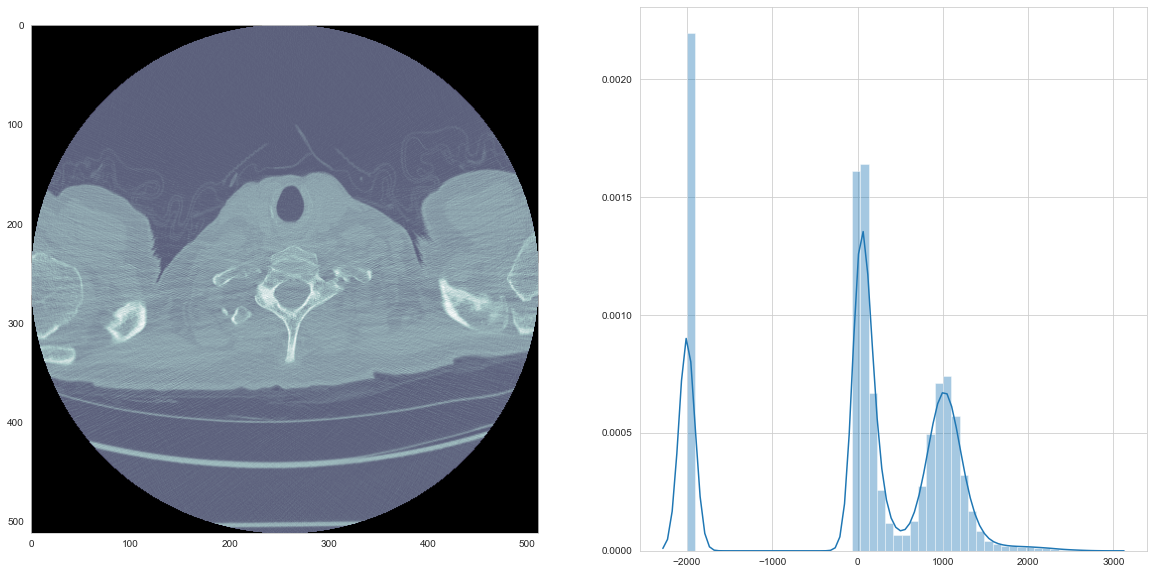

In [10]:
# plot a single image
# low values appear as dark, high values as light (MONOCHROME2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(dimg.pixel_array, cmap=plt.cm.bone)
axes[0].grid(False);
sns.distplot(dimg.pixel_array.flatten(), ax=axes[1]);

In [11]:
# Function to rescale pixels to common Hounsfield Units scale (https://en.wikipedia.org/wiki/Hounsfield_scale)
# Air: -1000
# Water: 0
# Bone: 300-3000
# Metal: 2000
def hu_scaled_px(dicom_image):
    # rescales per rescale slope and intercept
    img = dicom_image.pixel_array
    return img if dicom_image.Modality == "CR" else img * dicom_image.RescaleSlope + dicom_image.RescaleIntercept
hu_scaled_px(dimg)

array([[-3024., -3024., -3024., ..., -3024., -3024., -3024.],
       [-3024., -3024., -3024., ..., -3024., -3024., -3024.],
       [-3024., -3024., -3024., ..., -3024., -3024., -3024.],
       ...,
       [-3024., -3024., -3024., ..., -3024., -3024., -3024.],
       [-3024., -3024., -3024., ..., -3024., -3024., -3024.],
       [-3024., -3024., -3024., ..., -3024., -3024., -3024.]])

In [13]:
def extract_dicom_meta_data(filename: str) -> dict:
    # Load image
    
    image_data = pydicom.read_file(filename)
    img=np.array(image_data.pixel_array).flatten()
    row = {
        'Patient': image_data.PatientID,
        'body_part_examined': image_data.BodyPartExamined,
        'image_position_patient': image_data.ImagePositionPatient,
        'image_orientation_patient': image_data.ImageOrientationPatient,
        'photometric_interpretation': image_data.PhotometricInterpretation,
        'rows': image_data.Rows,
        'columns': image_data.Columns,
        'pixel_spacing': image_data.PixelSpacing,
        'window_center': image_data.WindowCenter,
        'window_width': image_data.WindowWidth,
        'modality': image_data.Modality,
        'StudyInstanceUID': image_data.StudyInstanceUID,
        'SeriesInstanceUID': image_data.StudyInstanceUID,
        'StudyID': image_data.StudyInstanceUID, 
        'SamplesPerPixel': image_data.SamplesPerPixel,
        'BitsAllocated': image_data.BitsAllocated,
        'BitsStored': image_data.BitsStored,
        'HighBit': image_data.HighBit,
        'PixelRepresentation': image_data.PixelRepresentation,
        'RescaleIntercept': image_data.RescaleIntercept,
        'RescaleSlope': image_data.RescaleSlope,
        'img_min': np.min(img),
        'img_max': np.max(img),
        'img_mean': np.mean(img),
        'img_std': np.std(img)}

    return row

In [17]:
meta_data_df = []
error_log = []
for filename in tqdm.tqdm(train_dcms):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        error_log.append((filename, e))
        continue
        
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
meta_data_df.to_csv('meta_data_df.csv', index=False)
meta_data_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 33026/33026 [03:12<00:00, 171.63it/s]


,Patient,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,...,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00007637202177411956430,Chest,"[-158.700, -153.500, -69.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512,512,"[0.652344, 0.652344]",-500.0,-1500.0,...,16,16,15,1,-1024.0,1.0,-2000,2842,-1.454884,1137.488858
1,ID00007637202177411956430,Chest,"[-158.700, -153.500, -159.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512,512,"[0.652344, 0.652344]",-500.0,-1500.0,...,16,16,15,1,-1024.0,1.0,-2000,2918,19.038597,1138.876560
2,ID00007637202177411956430,Chest,"[-158.700, -153.500, -169.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512,512,"[0.652344, 0.652344]",-500.0,-1500.0,...,16,16,15,1,-1024.0,1.0,-2000,2976,27.237549,1146.816206
3,ID00007637202177411956430,Chest,"[-158.700, -153.500, -179.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512,512,"[0.652344, 0.652344]",-500.0,-1500.0,...,16,16,15,1,-1024.0,1.0,-2000,2862,31.026043,1142.850763
4,ID00007637202177411956430,Chest,"[-158.700, -153.500, -189.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512,512,"[0.652344, 0.652344]",-500.0,-1500.0,...,16,16,15,1,-1024.0,1.0,-2000,2815,34.862141,1146.865109


In [20]:
len(error_log)

488

In [21]:
# examine dataframe
meta_data_df.columns

Index(['Patient', 'body_part_examined', 'image_position_patient',
       'image_orientation_patient', 'photometric_interpretation', 'rows',
       'columns', 'pixel_spacing', 'window_center', 'window_width', 'modality',
       'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID', 'SamplesPerPixel',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'RescaleIntercept', 'RescaleSlope', 'img_min', 'img_max', 'img_mean',
       'img_std'],
      dtype='object')

In [40]:
meta_data_df['Patient'].nunique()

173

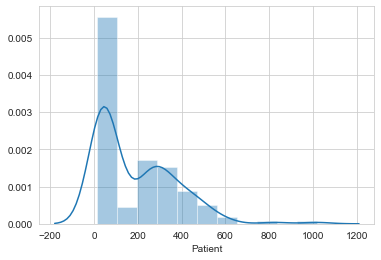

In [39]:
sns.distplot(meta_data_df['Patient'].value_counts());

In [30]:
meta_data_df['image_orientation_patient'].apply(lambda x: [int(a) for a in x]).value_counts()

[1, 0, 0, 0, 1, 0]      31758
[-1, 0, 0, 0, -1, 0]      627
[1, 0, 0, 0, -1, 0]        62
[0, 0, 0, 0, 1, 0]         53
[-1, 0, 0, 0, 1, 0]        38
Name: image_orientation_patient, dtype: int64

In [31]:
meta_data_df['photometric_interpretation'].value_counts()

MONOCHROME2    32538
Name: photometric_interpretation, dtype: int64

In [33]:
meta_data_df.groupby(['window_center','window_width']).size()

window_center  window_width
-1565.0         1383.0           238
-500.0         -1500.0         30424
                1400.0          1247
                1500.0           629
dtype: int64

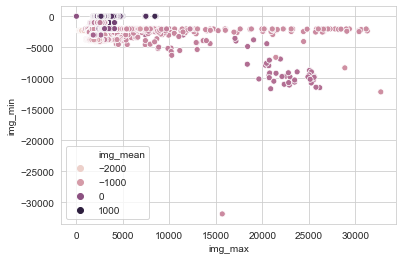

In [34]:
meta_data_df[]
sns.scatterplot(data = meta_data_df, x='img_max', y='img_min', hue='img_mean');

In [ ]:
# TODO: create formal training-testing dataframe with uniform orientation + window center/width
# 